<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Butterfly_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From the Stanford cars 196 dataset, model's are trained on the Cars dataset in an attempt to classify different images of cars. Several models will be used and performance results are compared.

https://www.kaggle.com/datasets/pnkjgpt/butterfly-classification-dataset

# Download Images

In [6]:
import torch
import torchvision

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download phucthaiv02/butterfly-image-classification

 90% 204M/226M [00:02<00:00, 148MB/s]
100% 226M/226M [00:02<00:00, 108MB/s]


In [11]:
from zipfile import ZipFile


with ZipFile("butterfly-image-classification.zip", 'r') as f:
  f.extractall("data/")

# Visualize the Data


In [12]:
import glob

images = glob.glob("data/train/*.jpg")
len(images)

6499

In [13]:
from PIL import Image
import random

random_img_name = random.choice(images)
random_img = Image.open(random_img_name)

In [14]:
from torchvision.transforms import v2
import matplotlib.pyplot as plt

transform = v2.Compose([v2.PILToTensor(),
                        v2.ToDtype(torch.float32, scale=True)])

transformed_img = transform(random_img)

In [15]:
transformed_img

tensor([[[0.3176, 0.3176, 0.3176,  ..., 0.3098, 0.3098, 0.3098],
         [0.3176, 0.3176, 0.3176,  ..., 0.3098, 0.3098, 0.3098],
         [0.3176, 0.3176, 0.3176,  ..., 0.3098, 0.3098, 0.3098],
         ...,
         [0.8549, 0.8431, 0.8314,  ..., 0.9922, 0.9922, 0.9922],
         [0.8627, 0.8510, 0.8314,  ..., 0.9922, 0.9922, 0.9922],
         [0.8627, 0.8549, 0.8314,  ..., 0.9922, 0.9922, 0.9922]],

        [[0.4471, 0.4471, 0.4471,  ..., 0.4627, 0.4627, 0.4627],
         [0.4471, 0.4471, 0.4471,  ..., 0.4627, 0.4627, 0.4627],
         [0.4471, 0.4471, 0.4471,  ..., 0.4627, 0.4627, 0.4627],
         ...,
         [0.8471, 0.8392, 0.8275,  ..., 0.9922, 0.9922, 0.9922],
         [0.8431, 0.8353, 0.8275,  ..., 0.9922, 0.9882, 0.9922],
         [0.8431, 0.8392, 0.8275,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [47]:
# Get the labels for each image
import csv

train_labels = {}

with open('data/Training_set.csv', 'r') as file:
   reader = csv.DictReader(file)
   for row in reader:
    key = row["filename"]
    value = row["label"]
    train_labels[key] = value


In [30]:
import os

name = os.path.basename(random_img_name)
name

'Image_5911.jpg'

In [31]:
len(images)

6499

Text(0.5, 1.0, 'ATALA')

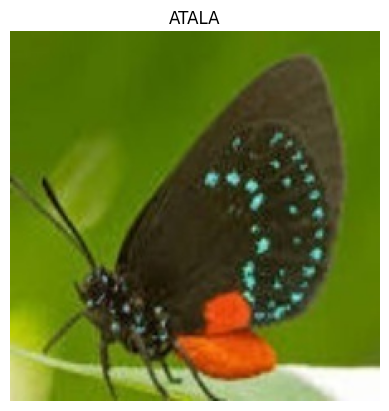

In [32]:
plt.imshow(transformed_img.permute(1,2,0))
plt.axis(False)
plt.title(train_labels[name])

In [33]:
transformed_img.shape

torch.Size([3, 224, 224])

## Create separate intro train and test dataset

The test dataset didn't have labels, so we are splitting the train dataset into train and test.

The Dataset get item inbuilt function needs to return a integer value for the class. We need a dictionary mapping between class name and index.

In [35]:
# Create the class to index dictionary

class_to_idx = {}
class_list = list(set(train_labels.values()))

for index, value in enumerate(class_list):
  class_to_idx[value] = index

class_to_idx

{'RED CRACKER': 0,
 'BANDED ORANGE HELICONIAN': 1,
 'MILBERTS TORTOISESHELL': 2,
 'EASTERN PINE ELFIN': 3,
 'JULIA': 4,
 'WOOD SATYR': 5,
 'SLEEPY ORANGE': 6,
 'MALACHITE': 7,
 'SOUTHERN DOGFACE': 8,
 'PIPEVINE SWALLOW': 9,
 'PAPER KITE': 10,
 'ELBOWED PIERROT': 11,
 'COPPER TAIL': 12,
 'CHECQUERED SKIPPER': 13,
 'COMMON WOOD-NYMPH': 14,
 'PURPLISH COPPER': 15,
 'BROWN SIPROETA': 16,
 'MOURNING CLOAK': 17,
 'QUESTION MARK': 18,
 'MONARCH': 19,
 'CLEOPATRA': 20,
 'CAIRNS BIRDWING': 21,
 'DANAID EGGFLY': 22,
 'RED POSTMAN': 23,
 'LARGE MARBLE': 24,
 'CABBAGE WHITE': 25,
 'BLUE MORPHO': 26,
 'BLUE SPOTTED CROW': 27,
 'MESTRA': 28,
 'CHESTNUT': 29,
 'AFRICAN GIANT SWALLOWTAIL': 30,
 'METALMARK': 31,
 'SILVER SPOT SKIPPER': 32,
 'PURPLE HAIRSTREAK': 33,
 'RED ADMIRAL': 34,
 'IPHICLUS SISTER': 35,
 'ATALA': 36,
 'CRIMSON PATCH': 37,
 'PAINTED LADY': 38,
 'VICEROY': 39,
 'PEACOCK': 40,
 'TROPICAL LEAFWING': 41,
 'GREAT JAY': 42,
 'POPINJAY': 43,
 'AMERICAN SNOOT': 44,
 'EASTERN DAPPLE WHITE':

In [131]:
from operator import indexOf
from torch.utils.data import Dataset
import pathlib

class CustomDataset(Dataset):
  def __init__(self,
               targ_dir: str,
               train: bool,
               class_list: list,
               class_to_idx: dict,
               train_labels: dict,
               transform=None):

    paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
    breakpoint = int(len(paths) * 0.8)
    if train:
      self.paths = paths[:breakpoint]
    else:
      self.paths = paths[breakpoint:]
    self.transform = transform
    self.classes = class_list
    self.class_to_idx = class_to_idx
    self.train_labels=train_labels
    self.transform = transform

  def load_image(self, index: int):
    """ Opens an image from a path """
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self):
    """ Gets the length of the dataset"""
    return len(self.paths)

  def __getitem__(self, idx:int):
    """ Returns one sample of data and label (X, y)"""
    img = self.load_image(idx)

    #Get the class name
    image_path = self.paths[idx]

    class_name = self.train_labels[image_path.stem + image_path.suffix]
    index = self.class_to_idx[class_name]

    if self.transform is not None:
      img = transform(img)

    return img, index


In [132]:
# Create Transforms

transform = v2.Compose([v2.PILToTensor(),
                         v2.ToDtype(torch.float32, scale=True),
                         v2.Resize(size=(224,224), antialias=True)])

In [133]:
# Create Datasets

# Setup some inputs
targ_dir = "/data/train"
class_list = list(set(train_labels.values()))
class_to_idx = {}
for index, value in enumerate(class_list):
  class_to_idx[value] = index



In [134]:
lst = list(pathlib.Path("data/train").glob("*.jpg"))
print(len(lst))

lst[0].stem + lst[0].suffix

6499


'Image_4969.jpg'

In [135]:
# Create Dataloaders

train_dataset = CustomDataset(targ_dir = "data/train",
                             train=True,
                             class_list=class_list,
                             class_to_idx=class_to_idx,
                             train_labels=train_labels,
                             transform=transform)

test_dataset = CustomDataset(targ_dir = "data/train",
                             train=False,
                             class_list=class_list,
                             class_to_idx=class_to_idx,
                             train_labels=train_labels,
                             transform=transform)

In [136]:
len(train_dataset), len(test_dataset)

(5199, 1300)

Image: torch.Size([3, 224, 224])
Label: 13
CHECQUERED SKIPPER


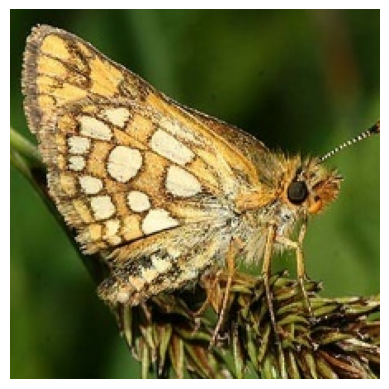

In [137]:

img, label = random.choice(train_dataset)

print(f"Image: {img.shape}")
print(f"Label: {label}")

plt.imshow(img.permute(1,2,0))
plt.axis(False)
print(class_list[label])

In [ ]:
# Create DataLoaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


# Create Different Models

# Testing Different Models

# Evaulate Model Performance